# api で diagnostics に提出する

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 
import yaml


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import LightGBMModel
from src.validation import caluculate_metrics

# Config

In [3]:
class cfg:
    exp = "exp019"
    dataset_path = "../dataset/v5.0"
    feature_set = "medium"
    valid_ratio = None
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
print(f"feature col length: {len(feature_set)}")


targets = feature_metadata["targets"]
targets = ["target", "target_agnes_20"]
targets = targets[0:1]
print(targets)


feature col length: 80
['target']


# Load Data

In [5]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 82)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_canonistic_disallowable_counterbore,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,1,2,3,2,3,2,2,2,3,...,4,0,2,2,3,2,2,3,2,0.25
n003bba8a98662e4,0001,3,2,4,1,0,2,3,2,4,...,4,3,2,2,4,1,2,3,2,0.25


(3590190, 82)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_canonistic_disallowable_counterbore,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,2,1,2,4,0,4,0,0,2,...,2,0,0,0,0,4,0,2,3,0.75
n001e1318d5072ac,0575,0,2,2,3,2,3,0,0,4,...,4,4,3,3,4,3,3,4,1,0.00


# Preprocess

In [6]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

# era 単位で分ける
all_era = data["era"].unique()

if cfg.valid_ratio:
    n_idx = int(len(all_era) * (1 - cfg.valid_ratio))

    train_era = all_era[:n_idx]
    cond_train = data["era"].isin(train_era)
else:
    cond_train = data["era"].isin(train["era"].values)
print(data.shape)

train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)


(2746270, 82) (3590190, 82)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_canonistic_disallowable_counterbore,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki,target
id,,,,,,,,,,,,,,,,,,,,,
nffddb5d88eac837,1155,1,3,3,0,1,0,1,4,4,...,4,4,0,0,1,2,0,1,3,NaN
nffe2864d87608a4,1155,2,2,0,4,4,1,0,0,2,...,1,0,1,0,4,3,1,2,0,NaN
nffe68d1b4270d67,1155,1,3,1,4,4,0,2,2,3,...,1,3,4,3,2,4,4,0,0,NaN
nffeedfcd8ee0a13,1155,2,2,0,4,0,1,0,4,2,...,2,1,1,3,0,4,1,2,3,NaN
nfff368efc94f367,1155,3,2,0,0,3,3,0,3,3,...,0,1,3,1,3,1,3,3,4,NaN


(6336460, 82)
(2746270, 82) (3590190, 82)


In [7]:
train["era_int"] = train["era"].astype(int)

/tmp/ipykernel_113860/1731592198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["era_int"] = train["era"].astype(int)


# Training

In [8]:
features = feature_set


In [9]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)
    for i in range(4):
        cond_train = (train["era_int"] % 4 == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train.loc[cond_train]
        tmp_valid = valid.loc[cond_valid]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 689317, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684034, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

4


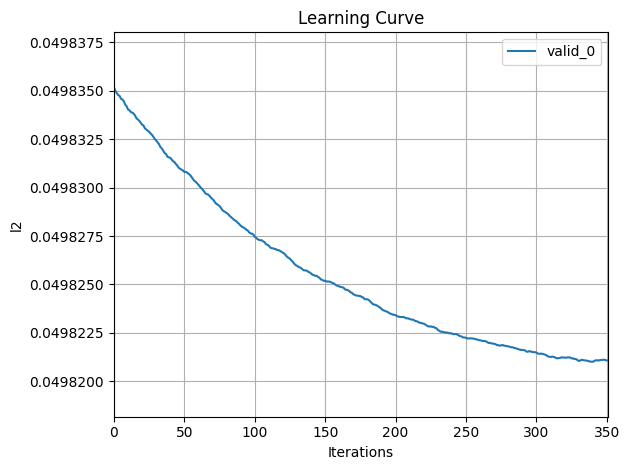

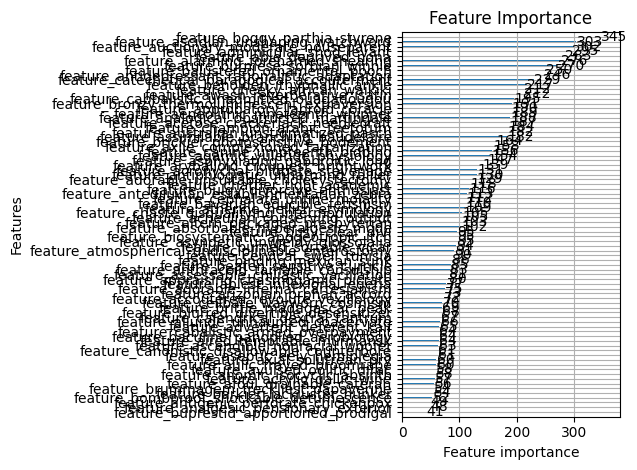

In [10]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

/tmp/ipykernel_113860/695934008.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["pred"] = preds


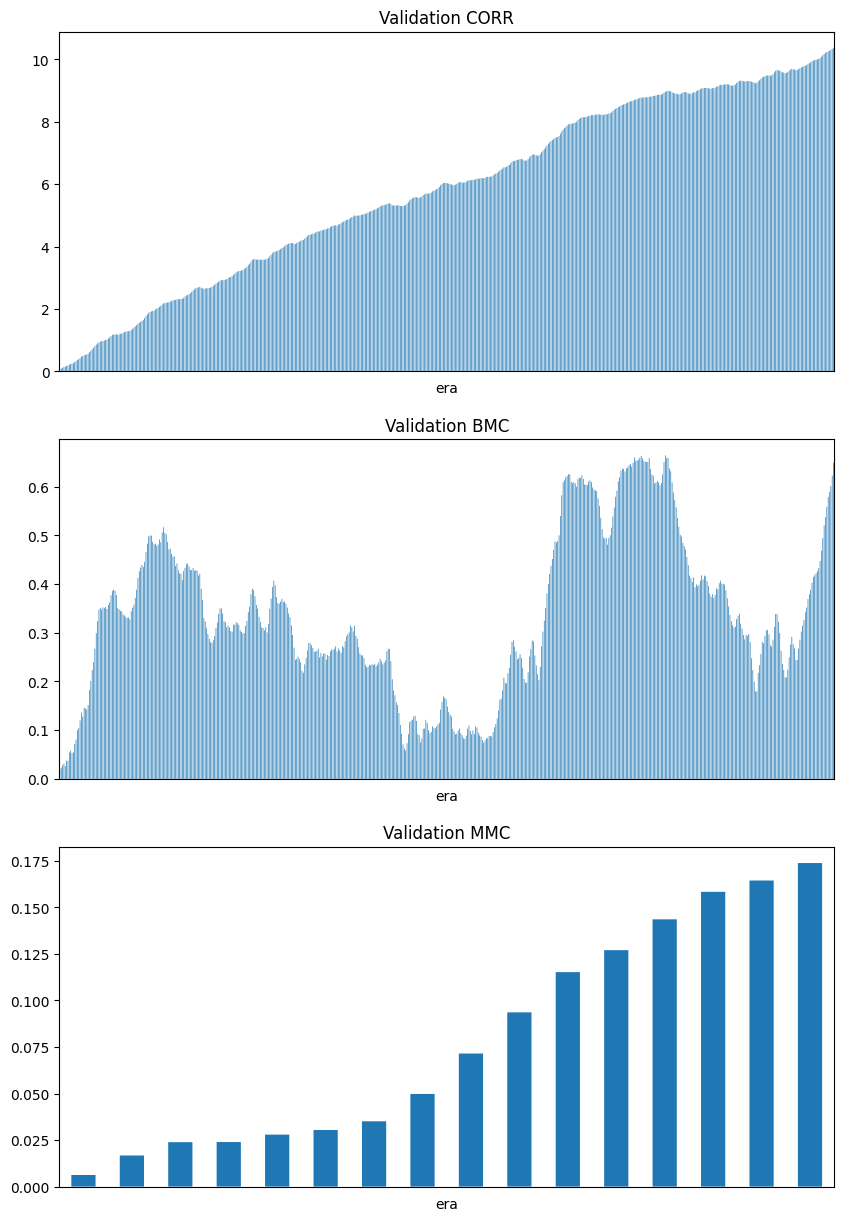

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0   0.018014  0.019498    0.923903           0.116672  0.010864  0.007098   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0   1.530445               0.0  0.001126  0.013504   0.083414   
 
    bmc_max_drawdown  
 0          0.484637  ,
           pred
 era           
 0575  0.056000
 0576  0.031171
 0577  0.026415
 0578  0.024788
 0579  0.010032
 ...        ...
 1146  0.021277
 1147  0.019168
 1148  0.022532
 1149  0.033660
 1150  0.039443
 
 [576 rows x 1 columns],
           pred
 era           
 0575  0.019327
 0576  0.003441
 0577  0.004925
 0578  0.003704
 0579 -0.004860
 ...        ...
 1146  0.020086
 1147  0.010374
 1148  0.012453
 1149  0.021342
 1150  0.026291
 
 [576 rows x 1 columns],
           pred
 era           
 1133  0.006230
 1134  0.010468
 1135  0.007161
 1136  0.000070
 1137  0.003987
 1138  0.002476
 1139  0.004691
 1140  0.014683
 1141  0.021721
 1142  0.022118

In [11]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
caluculate_metrics(cfg.dataset_path, valid)


In [20]:
valid["prediction"] = preds
valid_prediction_path = f"{cfg.exp}/prediction.csv"
valid[["prediction"]].to_csv(valid_prediction_path)

/tmp/ipykernel_113860/60407845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = preds


In [21]:
display(pd.read_csv(valid_prediction_path).head())

,id,prediction
0,n000101811a8a843,0.492597
1,n001e1318d5072ac,0.502862
2,n002a9c5ab785cbb,0.503161
3,n002ccf6d0e8c5ad,0.504371
4,n0041544c345c91d,0.498370


In [22]:
env_path = "../submissions/env.yaml"
with open(env_path, "r") as f:
    env = yaml.safe_load(f)
    
api = NumerAPI(env["api_key"], env["api_secret"])

model_d = api.get_models()
model_id = model_d["ko_ya346_6th"]



api.upload_diagnostics(valid_prediction_path, model_id=model_id)

2025-02-22 00:18:01,388 INFO numerapi.base_api: uploading diagnostics...


'b7847b6a-19fb-4ee6-a24b-1b415448c8de'